In [1]:
import pandas as pd
import numpy as np
import time

#grab the column names
first1000 = pd.read_csv('headers_first_1000.csv',index_col = 0)
cols = first1000.columns

#extract column level data from november dataset
#option to remove bots, remove server actions, and remove non-account users
def extract_col(f, col, 
                r_bot = True, 
                r_server = True, 
                rnon_user = True):
    tic = time.time()
    #choose only the columns that we need
    #browser type to get rid of bots
    #platform to get rid of server actions
    #user_id to get rid of users without accounts
    temp = pd.read_csv(f, names = cols, usecols = ['BR_TYPE','PLATFORM','USER_ID',col])
    toc = time.time()
    print('Time elapsed: ' + str(round(toc - tic, 2)) + 's')
    if r_bot:
        temp = temp[temp['BR_TYPE'] != 'Bot/Crawler']
    if r_server:
        temp = temp[temp['PLATFORM'] != 'srv']
    if rnon_user:
        temp = temp[~temp['USER_ID'].isnull()]
    tic = time.time()
    print('Narrowed data: ' + str(round(tic - toc, 2)) + 's')
    return temp

#get the sliced dataset for each of the files in november, then concatenate into one big dataframe
#it takes up around 3gb in memory in Python, which is pretty good! Since it's 15gb otherwise
d = [extract_col('novdata/nov'+fi+'.csv', 'GEO_COUNTRY') for fi in ['1','2','3','4','5']]
fulld = pd.concat(d)
fulld

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Time elapsed: 30.04s
Narrowed data: 1.37s
Time elapsed: 28.9s
Narrowed data: 1.14s
Time elapsed: 29.82s
Narrowed data: 1.21s
Time elapsed: 15.74s
Narrowed data: 0.53s
Time elapsed: 28.71s
Narrowed data: 1.43s


,BR_TYPE,PLATFORM,USER_ID,GEO_COUNTRY
0,BR_TYPE,PLATFORM,USER_ID,GEO_COUNTRY
5,Browser,web,4271489,CA
8,Browser,web,1208503,US
10,Browser,web,3376465,US
17,Browser,web,2864521,CA
...,...,...,...,...
4697905,Browser,web,364941.0,DK
4697906,Browser,web,364941.0,DK
4697907,Browser,web,364941.0,DK
4697914,Browser,web,3301919.0,US


In [3]:
#may have to install geopandas
from matplotlib import pyplot as plt
import geopandas as gp

fulld = fulld.drop(index = 0)
#create a dataframe consisting of the unique iso_alpha2 country codes and the number of actions
country_counts = pd.DataFrame(fulld['GEO_COUNTRY'].value_counts())
country_counts = country_counts.rename({'GEO_COUNTRY':'Count'},axis=1)
country_counts

,Count
US,5732474
CA,867563
AU,418770
DE,327329
GB,287412
...,...
XK,3
BT,3
VA,2
ER,1


In [4]:
import pycountry

#convert alpha2 to alpha3 (to match geopandas world database)
a3 = []
for r in country_counts.index:
    try:
        a3.append(pycountry.countries.get(alpha_2=r).alpha_3)
    except:
        a3.append(None)
country_counts['a3'] = a3
#set Kosovo to -99 (there's one other country with -99 but it's Somaliland (negligble))
country_counts.loc['XK','a3'] = '-99'
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
country_counts[country_counts.index == 'XK']

,Count,a3
XK,3,-99


In [5]:
#France and Norway are mislabeled in the geopandas dataset, set their iso_alpha3s to be the right 3 letter codes
world.loc[world[world['name'] == 'France'].index.values[0],'iso_a3'] = 'FRA'
world.loc[world[world['name'] == 'Norway'].index.values[0],'iso_a3'] = 'NOR'

#merge the geopandas world database with our counts of user activity
world_with_counts = world.merge(country_counts, left_on = 'iso_a3', right_on = 'a3', how = 'left').drop(columns='a3')

#create a weighted metric (actions per (multiple) people) which is more interpretable than per person (<1)
multiple = 1000
world_with_counts['Per_1000'] = multiple*world_with_counts['Count'] / world_with_counts['pop_est']
world_with_counts

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Count,Per_1000
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",285.0,0.309467
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",3826.0,0.070916
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",867563.0,24.353548
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",5732474.0,17.550586
...,...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",999.0,0.140486
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",41.0,0.063808
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",3.0,0.001583
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",1260.0,1.034306


Total Amount of Website Actions:  9033682.0
Actions per 1000 across the whole area:  0.0012235646069212777
Hotspot countries:  ['United States of America' 'Canada' 'Australia' 'Germany'
 'United Kingdom']


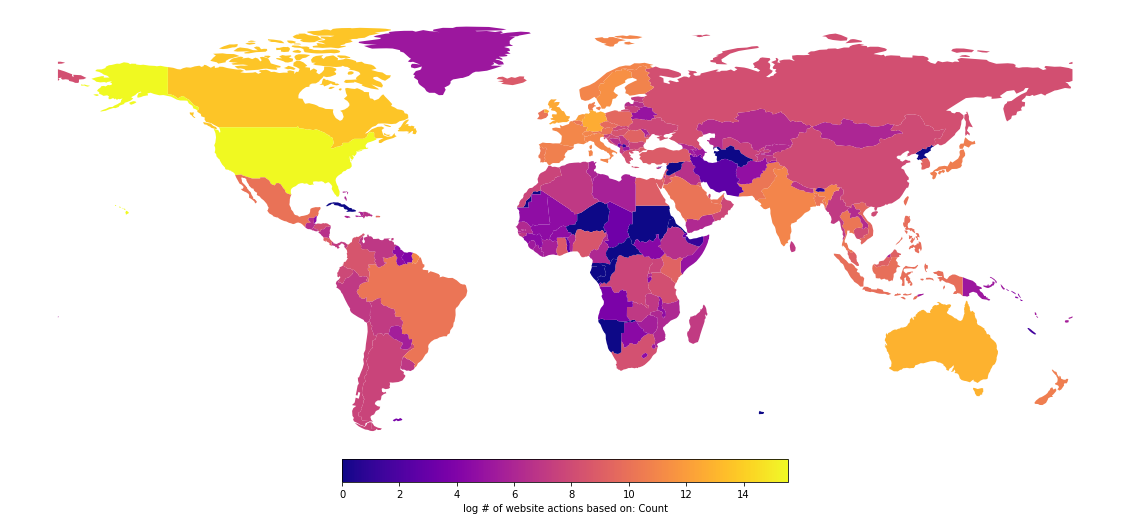

In [69]:
#generates a user activity plot based on data that satisfy the given condition
def generate_user_plot(condition, 
                       title = None, #save the figure
                       weighted = True, #weight user activity by population
                       log = False,#take the log to better inspect small differences
                       leg = True):
    fig,ax = plt.subplots(1,1,figsize = (20,15))
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.axis('off')
    
    #use either Count or Per1000, based on whether or not it should be weighted
    extra = 'Count' if not weighted else 'Per_1000'
    k = world_with_counts[condition].fillna(world_with_counts[condition][extra].min())
    lab = '# of website actions based on: ' + extra
    if log:
        k['log' + extra] = np.log(k[extra])
        lab = 'log ' + lab
        extra = 'log' + extra
    k.plot(column = extra, 
           ax = ax, 
           legend = leg, 
           legend_kwds = {'label':lab,
                          'orientation':'horizontal',
                          'pad':0.01, 'shrink':0.4},
           cmap = 'plasma')
    if title:
        plt.savefig(title, bbox_inches = 'tight', pad_inches = 0)
    
    #print some statistics
    print('Total Amount of Website Actions: ',k['Count'].sum())
    print('Actions per 1000 across the whole area: ',k['Count'].sum() / k['pop_est'].sum())
    print('Hotspot countries: ',k.sort_values('Count',ascending=False)['name'][:5].values)

#red countries are those we don't have data on
generate_user_plot(world_with_counts['continent'] != 'Antarctica', 
                   title = 'World_Activity_Nov20_log', 
                   weighted = False, 
                   log = True,
                   leg = True)

Total Amount of Website Actions:  381655.0
Actions per 1000 across the whole area:  8.695429553545555e-05
Hotspot countries:  ['India' 'Japan' 'Thailand' 'Pakistan' 'Bangladesh']


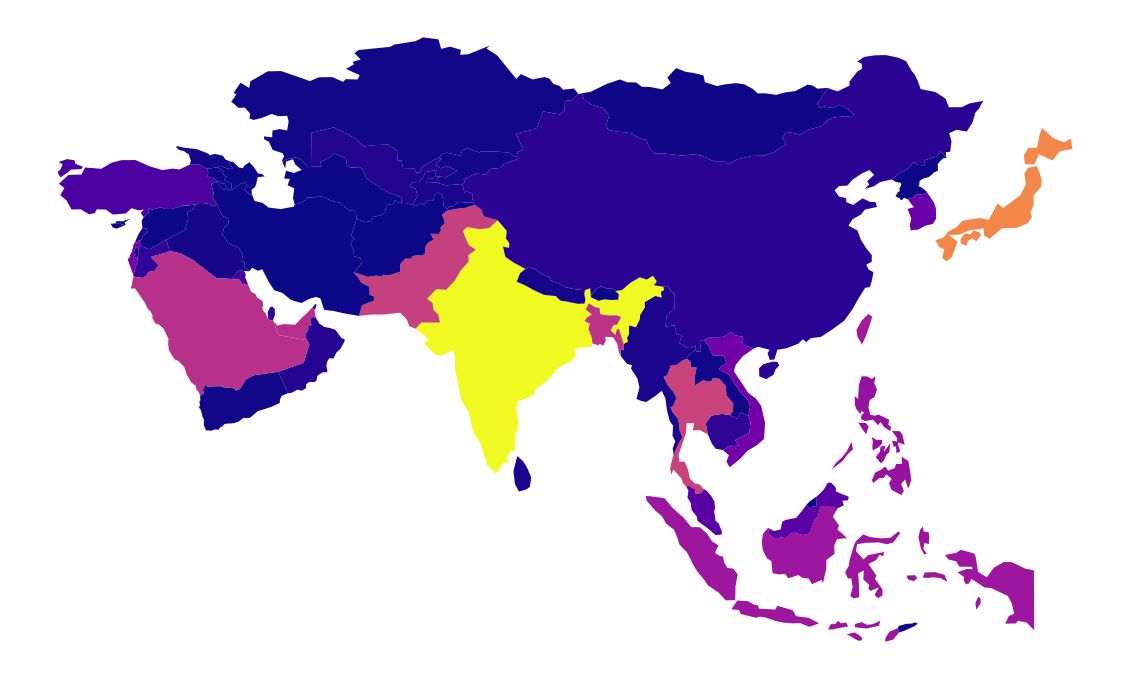

In [74]:
generate_user_plot((world_with_counts['continent'] == 'Asia') & (world_with_counts['name'] != 'Russia'), title = 'europe', weighted = False,leg = False)

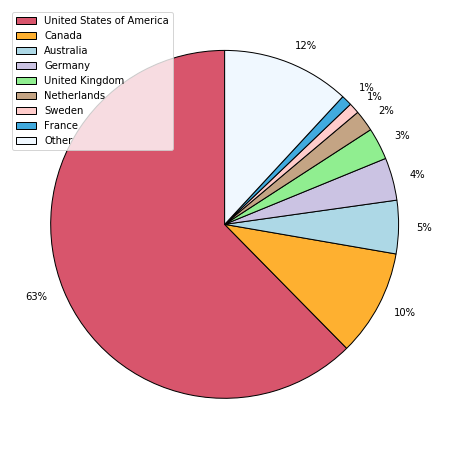

In [154]:
import seaborn as sns

#summary statistics
world_with_counts['Prop_of_Total'] = world_with_counts['Count'] / world_with_counts['Count'].sum()
topworld = world_with_counts.sort_values('Count',ascending=False).iloc[:8,:]
otherprop = world_with_counts.sort_values('Count',ascending=False).iloc[8:,:]['Count'].sum() / world_with_counts['Count'].sum()
x = np.append(topworld['name'].values, 'Other')
y = np.round(np.append(topworld['Prop_of_Total'].values, otherprop),2)*100

plt.figure(figsize=(8,8))
plt.pie(y, 
        labels = [str(i)[:-2] + '%' for i in y], 
        startangle = 90, 
        colors = ['#D8556C','#FEB030','#ADD8E6',
                  '#CBC3E3','#90EE90','#C4A484',
                  '#ffcccb','#41AADE','#F0F8FF'],
        wedgeprops = {'edgecolor':'0'})
plt.legend(labels = x, loc = 'best')
plt.savefig('summary_props', bbox_inches = 'tight')